In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

In [3]:
# Tutorial stuff
from __future__ import absolute_import, division, print_function, unicode_literals

In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [5]:
tf.__version__

'1.14.0'

In [6]:
import datasets
from datasets import loadTFRD

In [7]:
# Enable premature calculations
# Eager execution provides an imperative interface to TensorFlow.
# With eager execution enabled, TensorFlow functions execute operations immediately
# (as opposed to adding to a graph to be executed later in a tf.compat.v1.Session)
# and return concrete values (as opposed to symbolic references to a node in a computational graph).
tf.enable_eager_execution()

In [8]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print("GPU available : " + str(tf.test.is_gpu_available()))
print("Number of GPUS available : %d" % len(gpus))

GPU available : False
Number of GPUS available : 0


In [ ]:
# See what device (GPU or CPU) tensorflow is using
tf.debugging.set_log_device_placement(True)

In [ ]:
# Test case
a = tf.constant([[1.0, 2.0, 3.0],
                 [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0],
                 [3.0, 4.0],
                 [5.0, 6.0]])

In [ ]:
# Test case (cont.)
c = tf.matmul(a, b)
print(c)

In [ ]:
# Need tensorflow-gpu to use gpus
# pip uninstall tensorflow
# pip install tensorflow-gpu

In [9]:
# dataset paths
train_path = "audio_tfrd/train.tfrecords"
val_path = "audio_tfrd/val.tfrecords"
test_path = "audio_tfrd/test.tfrecords"

In [10]:
# load datasets
batch_size = 8
train_ds = loadTFRD(train_path, True, batch_size)
val_ds = loadTFRD(val_path, True, batch_size)
test_ds = loadTFRD(test_path, True, batch_size)

(8, 44100, 1)


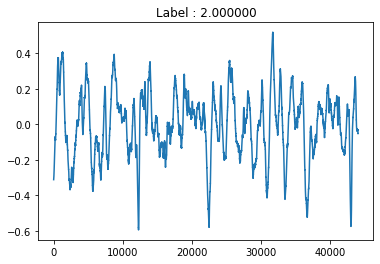

In [11]:
f_sample = 44100

batch_num = 0
for audio, lbl in train_ds.take(1):
    print(audio.shape)
    plt.plot(audio.numpy()[batch_num])
    plt.title("Label : %f" % lbl[batch_num])

In [12]:
# Count elements in train_ds
train_ct = 0
for audio, lbl in  train_ds:
    train_ct += 1
print(train_ct)

72


In [13]:
val_ct = 0
for audio, lbl in  val_ds:
    val_ct += 1
print(val_ct)

10


In [14]:
test_ct = 0
for audio, lbl in  test_ds:
    test_ct += 1
print(test_ct)

20


In [15]:
# train_ct = 578
# val_ct = 82
# test_ct = 164

In [16]:
# Make repeatable datasets for training, so we can iterate over them as many times as we please
train_ds = train_ds.repeat(None)
val_ds = val_ds.repeat(None)
test_ds = test_ds.repeat(None)

In [17]:
####
# Simple LSTM model
# Class definition : https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM
# Tutorial : https://www.tensorflow.org/tutorials/structured_data/time_series

In [18]:
####
# Build a model class

class LSTM(tf.keras.Model):
    
    def __init__(self):
        super(LSTM, self).__init__()
        self.LSTM = tf.keras.layers.LSTM(8, input_shape = (44100, 1)) # Argument 1 : number of output features
        # Argument 2 : input_shape = # time points
        # input_shape is necessary for automatic shape inference
        self.dense = tf.keras.layers.Dense(8) # Argument 1 : number of output classes
        
    def call(self, data):
        data = self.LSTM(data)
        data = self.dense(data)
        data = tf.nn.softmax(data, axis = 1)
        return data

In [19]:
model = LSTM()

In [20]:
model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [ ]:
log_dir = "./runs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [ ]:
cp_path = "training_2/cp-{epoch:04d}.h5py"
cp_dir = os.path.dirname(cp_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = cp_path,
                                                 verbose = 1,
                                                 save_weights_only = True,
                                                 period = 1)

In [ ]:
print("Initiating Training.")
model.save_weights(cp_path.format(epoch = 0)) # Save initial model weights
model.fit(train_ds, epochs = 10, validation_data = val_ds, steps_per_epoch = train_ct, validation_steps = val_ct, shuffle = True, callbacks = [cp_callback, tensorboard_callback])
print("Finished Training.")

In [27]:
####
# Load model
model_reloaded = LSTM()

In [28]:
model_reloaded.load_weights("./training_2/cp-0009.h5py")

In [30]:
model_reloaded.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [31]:
####
# Evaluate the model
model_reloaded.evaluate(test_ds, steps = test_ct)

20/20 [==============================] - 80s 4s/step - loss: 39.7173 - acc: 0.4810


[39.717348670959474, 0.475]

In [32]:
model_reloaded.summary()

Model: "lstm_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                multiple                  320       
_________________________________________________________________
dense_2 (Dense)              multiple                  72        
Total params: 392
Trainable params: 392
Non-trainable params: 0
_________________________________________________________________
